## Set up Environment

### Run in terminal

conda create --name fire python=3.9.13

conda activate fire

conda install -y jupyter pandas numpy matplotlib geopandas seaborn xarray numpy glob2 rioxarray scipy

In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt
from datetime import datetime
import geopandas as gpd
import seaborn as sns
import pickle as pkl
import pandas as pd
import xarray as xr
import numpy as np
import os
import glob
import warnings
import rioxarray
from zipfile import ZipFile
from collections import OrderedDict
from shapely.geometry import mapping, Point, Polygon
warnings.filterwarnings('ignore')
from scipy.spatial.distance import euclidean

# Small style adjustments for more readable plots
plt.style.use("seaborn-whitegrid")
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams["font.size"] = 14
plt.rcParams["figure.dpi"] = 600
sns.set()

# [Sierra Nevada](https://gis.data.cnra.ca.gov/datasets/727b3cc24f8549759fe946a298dc3a20_0/explore?location=36.354762%2C-118.192418%2C5.00)


,minx,miny,maxx,maxy
0,-123.039369,35.064857,-117.735372,41.994914


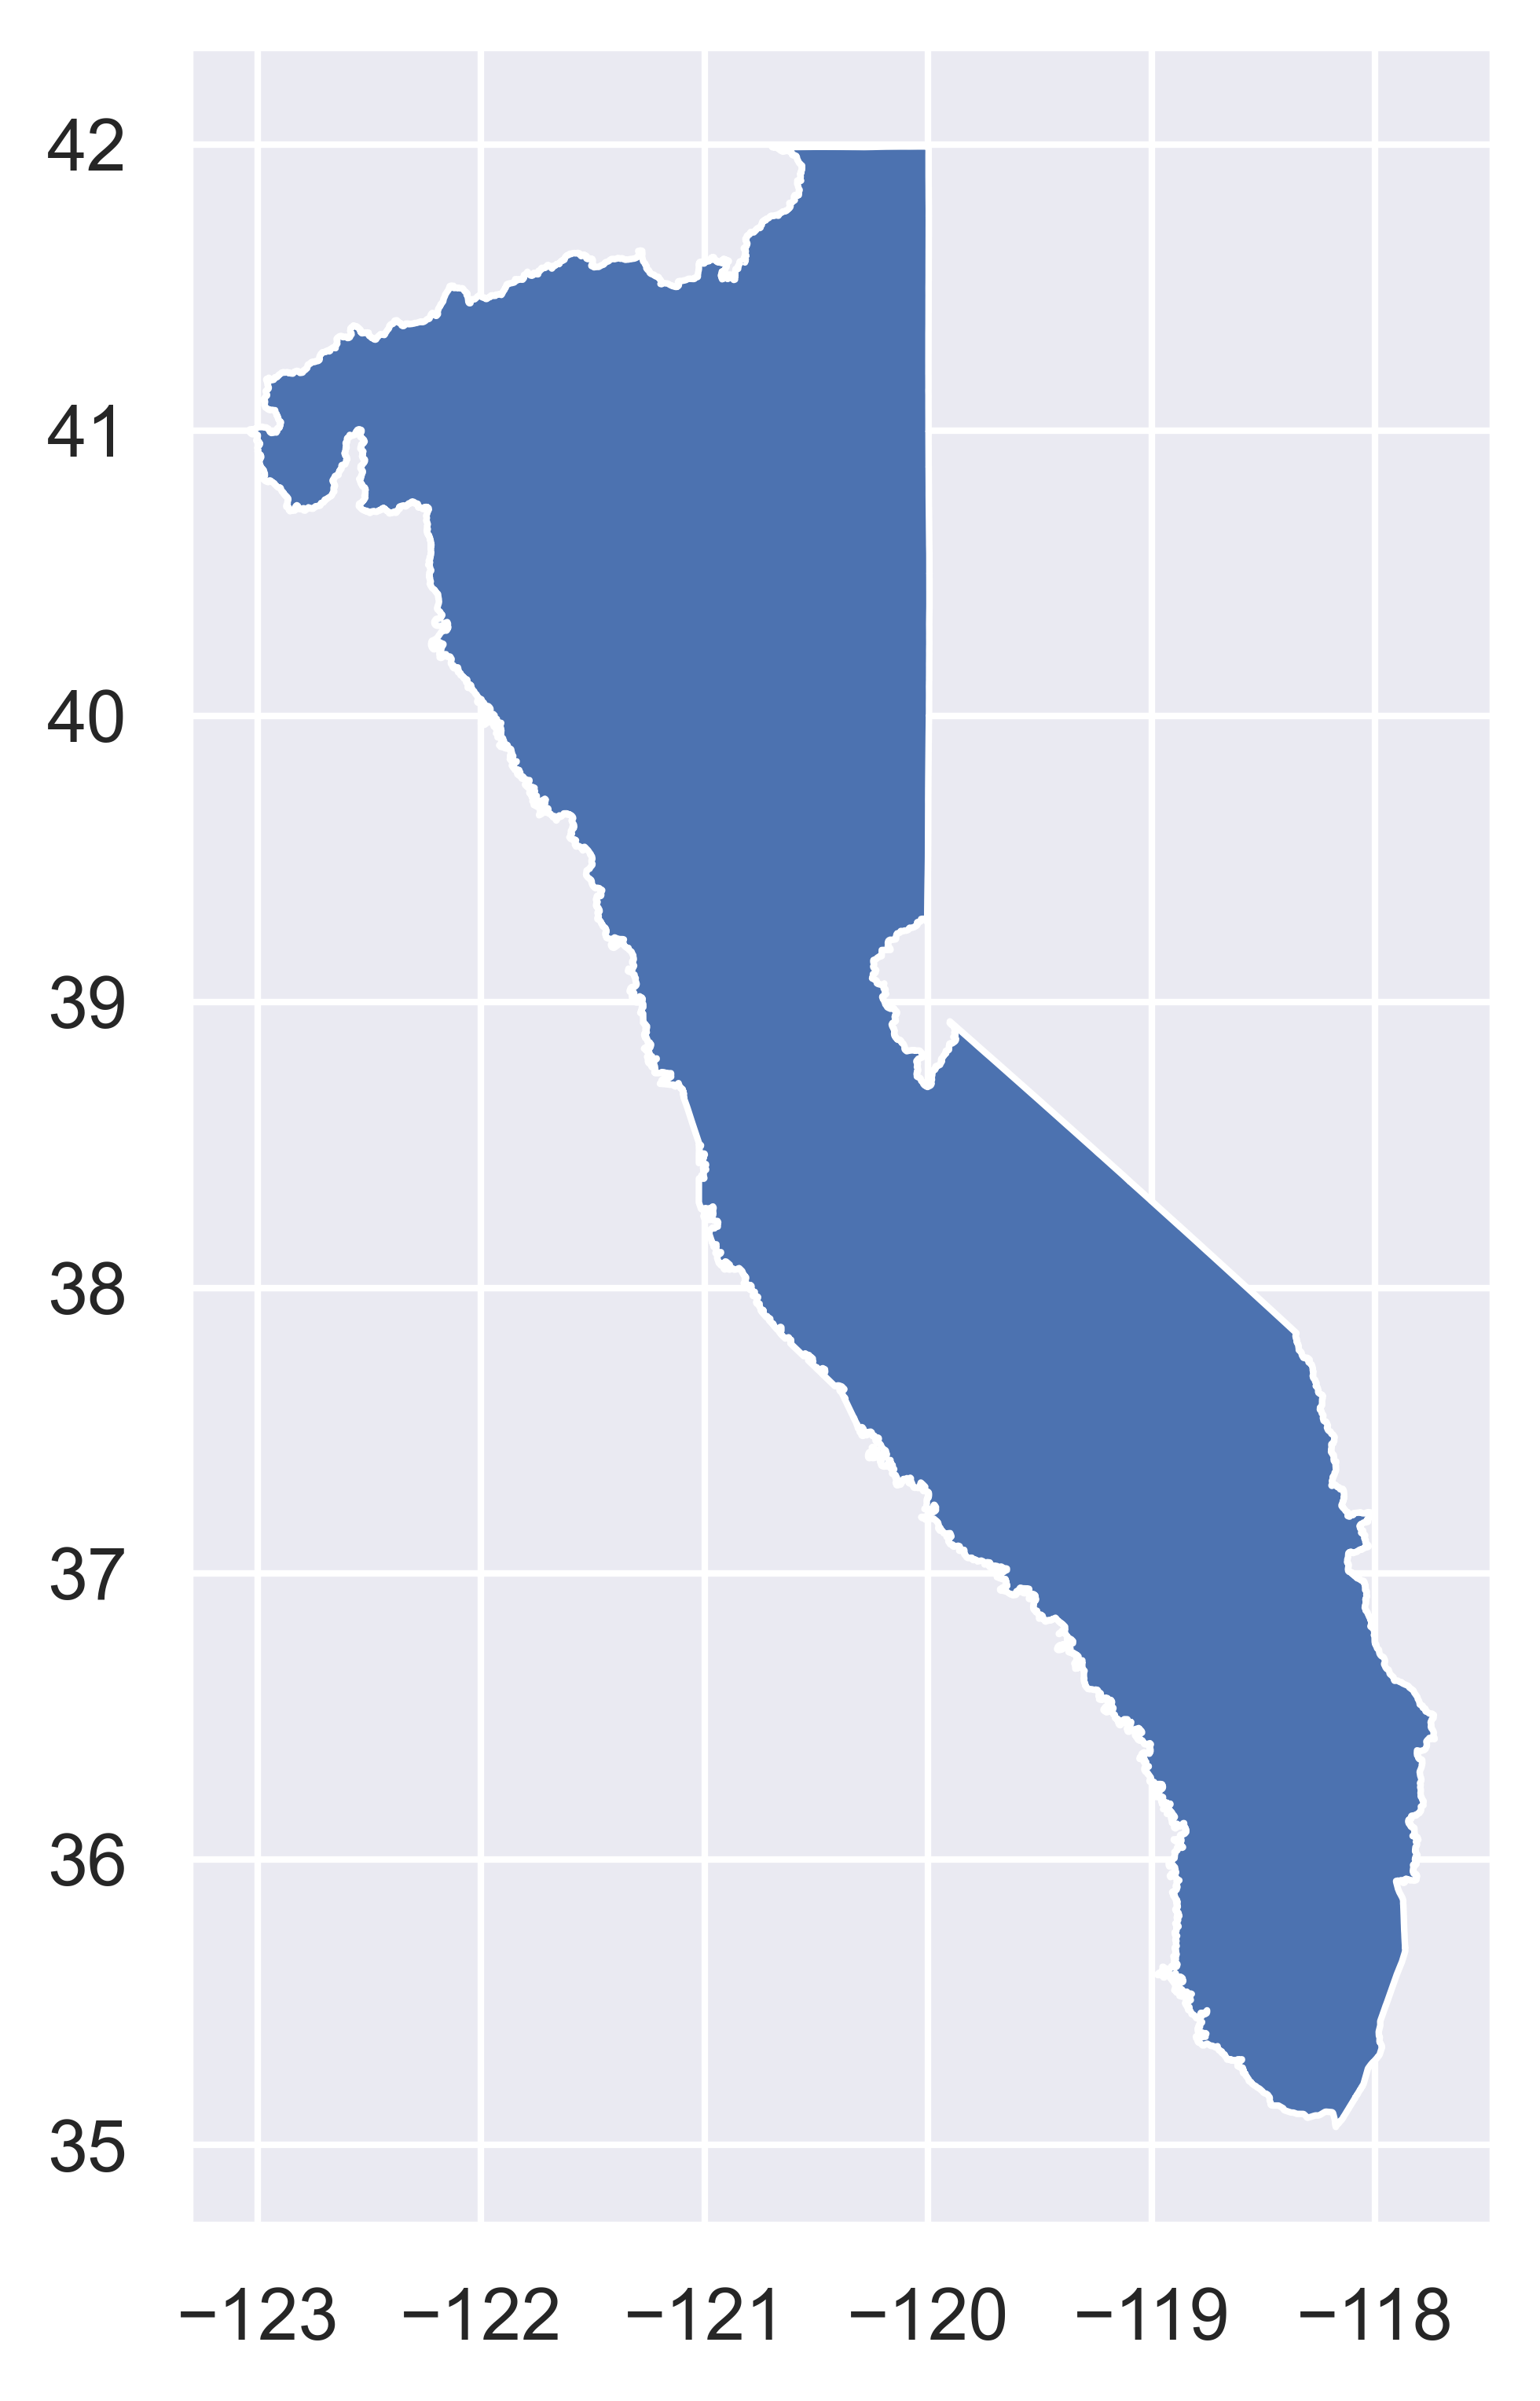

In [2]:
snBoundaries = gpd.GeoDataFrame.from_file(r'zip://data/sierraNevada.zip').to_crs(epsg=4326)
snBounds = snBoundaries.geometry.bounds
display(snBounds)
snBoundaries.plot();

## Only Northern Sierra Nevada

Includes Tahoe, Plumas, and Lassen National Forest

<AxesSubplot: >

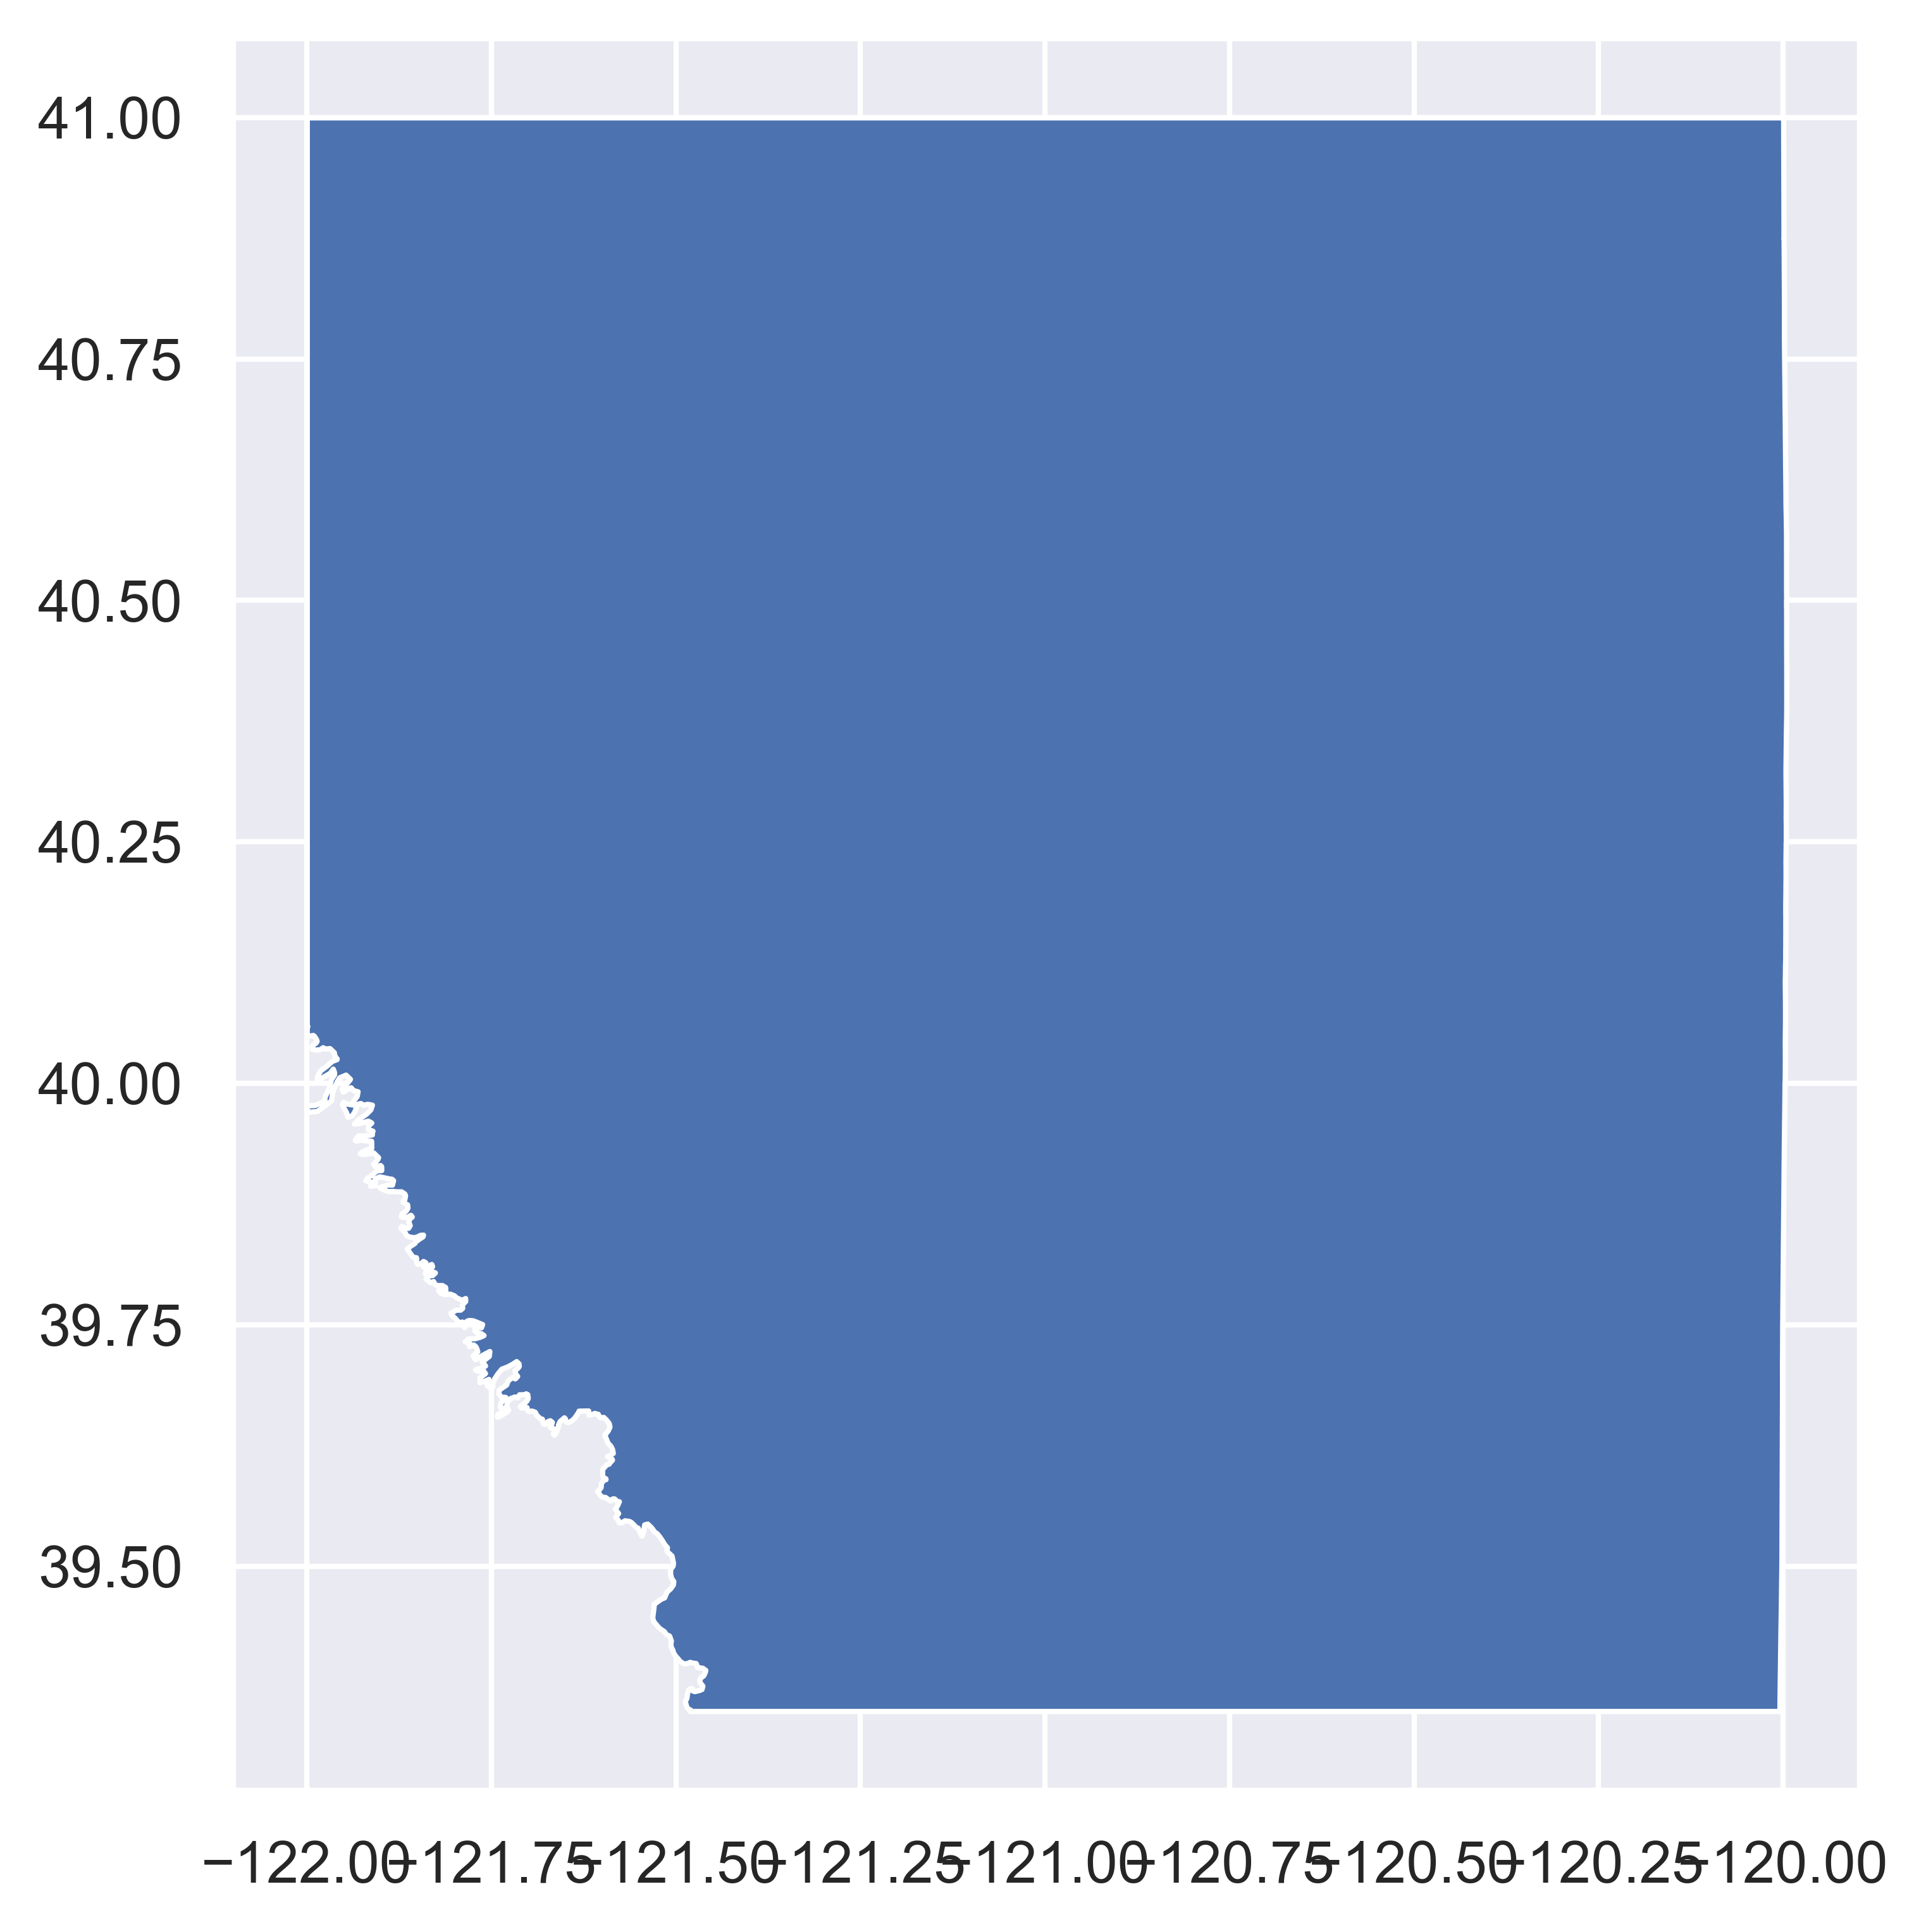

In [3]:
bounds = [-122, 39.35, snBounds.iloc[0].maxx, 41] #
boundaries = gpd.clip(snBoundaries, bounds)
bounds = boundaries.geometry.bounds
boundaries.plot()

# [Fire Perimeter](https://frap.fire.ca.gov/frap-projects/fire-perimeters/)
 
|cause code|description|cause code|description|
|:--:|:--|:--:|:--|
|1 |Lightning         |11|Power Line
|2 |Equipment Use     |12|Firefighter Training
|3 |Smoking           |13|Non-Firefighter Training
|4 |Campfire          |14|Unknown/Unidentified
|5 |Debris            |15|Structure
|6 |Railroad          |16|Aircraft
|7 |Arson             |17|Volcanic
|8 |Playing with Fire |18|Escaped Prescribed Burn
|9 |Miscellaneous     |19|Illegal Alien Campfire
|10|Vehicle

In [4]:
# clean data
firePer = gpd.GeoDataFrame.from_file(r'zip://data/fire21_1.gdb.zip').to_crs(epsg=4326)
firePer = firePer[firePer.YEAR_.isin(['2017','2018','2019','2020','2021',])]
firePer = firePer[firePer.STATE == 'CA']
firePer = firePer.dropna(subset=['ALARM_DATE', 'CONT_DATE'])
firePer = gpd.clip(firePer, boundaries) # fires in area
firePer = firePer.drop(index=342) # error date: 0202-08-20
firePer['ALARM_DATE'] = pd.to_datetime(firePer.ALARM_DATE.astype(str).str[:10], format='%Y-%m-%d')
firePer['CONT_DATE']  = pd.to_datetime(firePer.CONT_DATE.astype(str).str[:10], format='%Y-%m-%d')
firePer = firePer.sort_values('ALARM_DATE').reset_index(drop=True)
# print(np.sort(firePer.CAUSE.unique()))

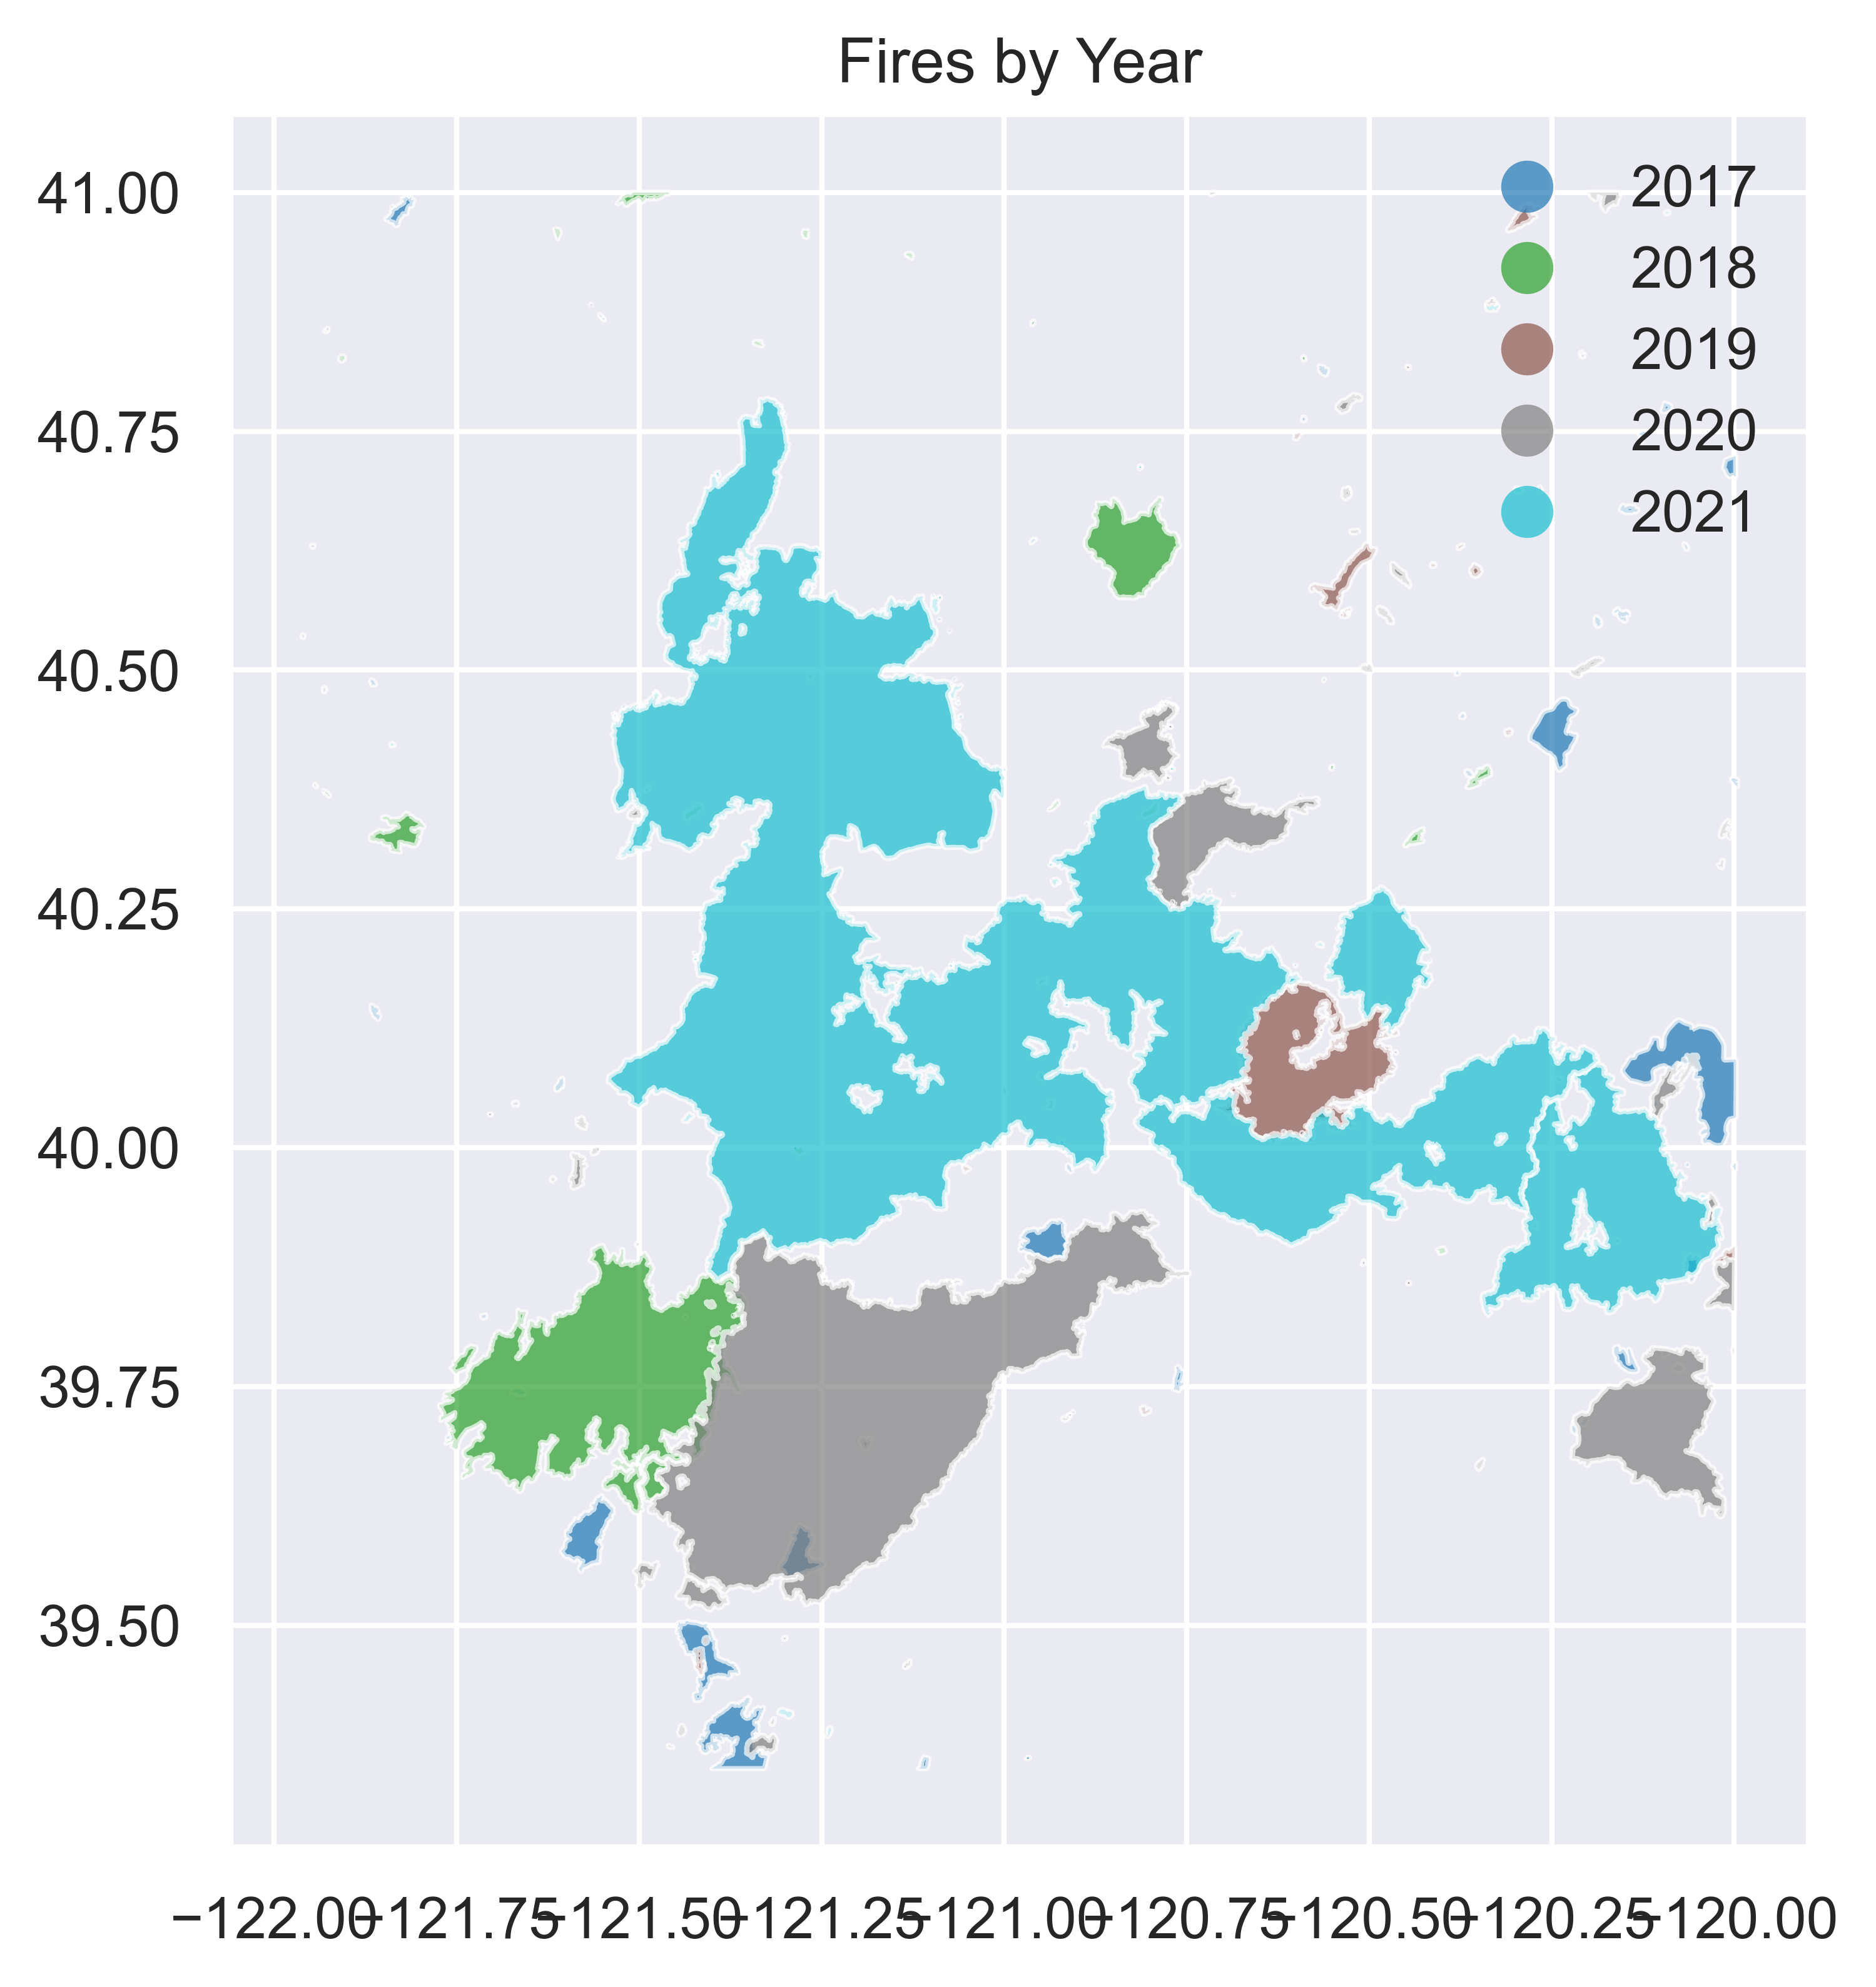

In [5]:
firePer.plot('YEAR_', legend=True, alpha=0.7);
plt.title('Fires by Year');

# GRIDMET

### Resources
- [GRIDMET](https://developers.google.com/earth-engine/datasets/catalog/IDAHO_EPSCOR_GRIDMET)
- [Download NetCDF Data](https://www.climatologylab.org/gridmet.html)
- [NFDRS fire danger index](https://www.nwcg.gov/publications/pms437/fire-danger/nfdrs-system-inputs-outputs)

### Description
- What starts a fire? high winds, high temperatures, low humidity
- Years: 2017-2021
- Resolution: 4638.3 meters = 4.6383 km
- The key inputs into the NFDRS model are: fuels, weather, topography and risks. 

| variable | var | units | description |
|:--:|:--:|:--:|:--:|
| relative_humidity | rmin | %   | minimum relative humidity |
| air_temperature   | tmmx | K   | maximum temperature |
| wind_speed        | vs   | m/s | wind velocity at 10m |
| burning_index_g   | bi   | NFDRS fire danger index | burning index | 

#### Download Data
- **brew install wget** in terminal or somewhere else
- won't redownload data if files exist in directory data/gm/

In [6]:
# # !ls
# %cd data
# if not os.path.exists('gm/'): os.makedirs('gm/')
# %cd gm
# ! ../metdata_wget.sh
# %cd ../../
# !ls

In [7]:
def clip(f, res, boundaries=boundaries, x_dim='lon', y_dim='lat', fire=False):
    minLon = bounds.iloc[0].minx - res
    maxLon = bounds.iloc[0].maxx + res
    maxLat = bounds.iloc[0].maxy + res
    minLat = bounds.iloc[0].miny - res
    d = xr.open_dataset(f)
    var = list(d.keys())[0]
    d = d[var].sel(lon=slice(minLon,maxLon), lat=slice(maxLat,minLat))
    if fire==True: boundaries=firePer
    d.rio.write_crs("epsg:4326", inplace=True)
    d.rio.set_spatial_dims(x_dim=x_dim, y_dim=y_dim, inplace=True)
    d = d.rio.clip(boundaries.geometry.apply(mapping), 
                   boundaries.crs, drop=False)
    return d

In [8]:
# include 2 more pixel on all sides around ca perimeter
# gridmet resolution: 1/24 or 4km
res = (2/24)
ds = []
for f in np.sort(glob.glob('data/gm/*.nc')):
    da = clip(f, res)
    da = da.drop('crs')
    ds.append(da)
ds = xr.merge(ds) # merge all gridmet vars
# ds.to_netcdf('data/gridmet.nc')
ds.dims

Frozen({'lon': 52, 'lat': 44, 'day': 1826})

In [9]:
res = (2/24)
dsFire = []
for f in np.sort(glob.glob('data/gm/*.nc')):
    da = clip(f, res, fire=True)
    da = da.drop('crs')
    dsFire.append(da)
dsFire = xr.merge(dsFire) # merge all gridmet vars
# ds.to_netcdf('data/gridmet.nc')
dsFire.dims

Frozen({'lon': 52, 'lat': 44, 'day': 1826})

In [10]:
ds

<xarray.Dataset>
Dimensions:            (lon: 52, lat: 44, day: 1826)
Coordinates:
  * lon                (lon) float64 -122.1 -122.0 -122.0 ... -120.0 -119.9
  * lat                (lat) float64 41.07 41.03 40.98 ... 39.36 39.32 39.28
  * day                (day) datetime64[ns] 2017-01-01 2017-01-02 ... 2021-12-31
Data variables:
    burning_index_g    (day, lat, lon) float32 nan nan nan nan ... nan nan nan
    relative_humidity  (day, lat, lon) float32 nan nan nan nan ... nan nan nan
    air_temperature    (day, lat, lon) float32 nan nan nan nan ... nan nan nan
    wind_speed         (day, lat, lon) float32 nan nan nan nan ... nan nan nan
Attributes:
    units:              Unitless
    description:        BI-G
    long_name:          bi
    standard_name:      bi
    dimensions:         lon lat time
    grid_mapping:       crs
    coordinate_system:  WGS84,EPSG:4326

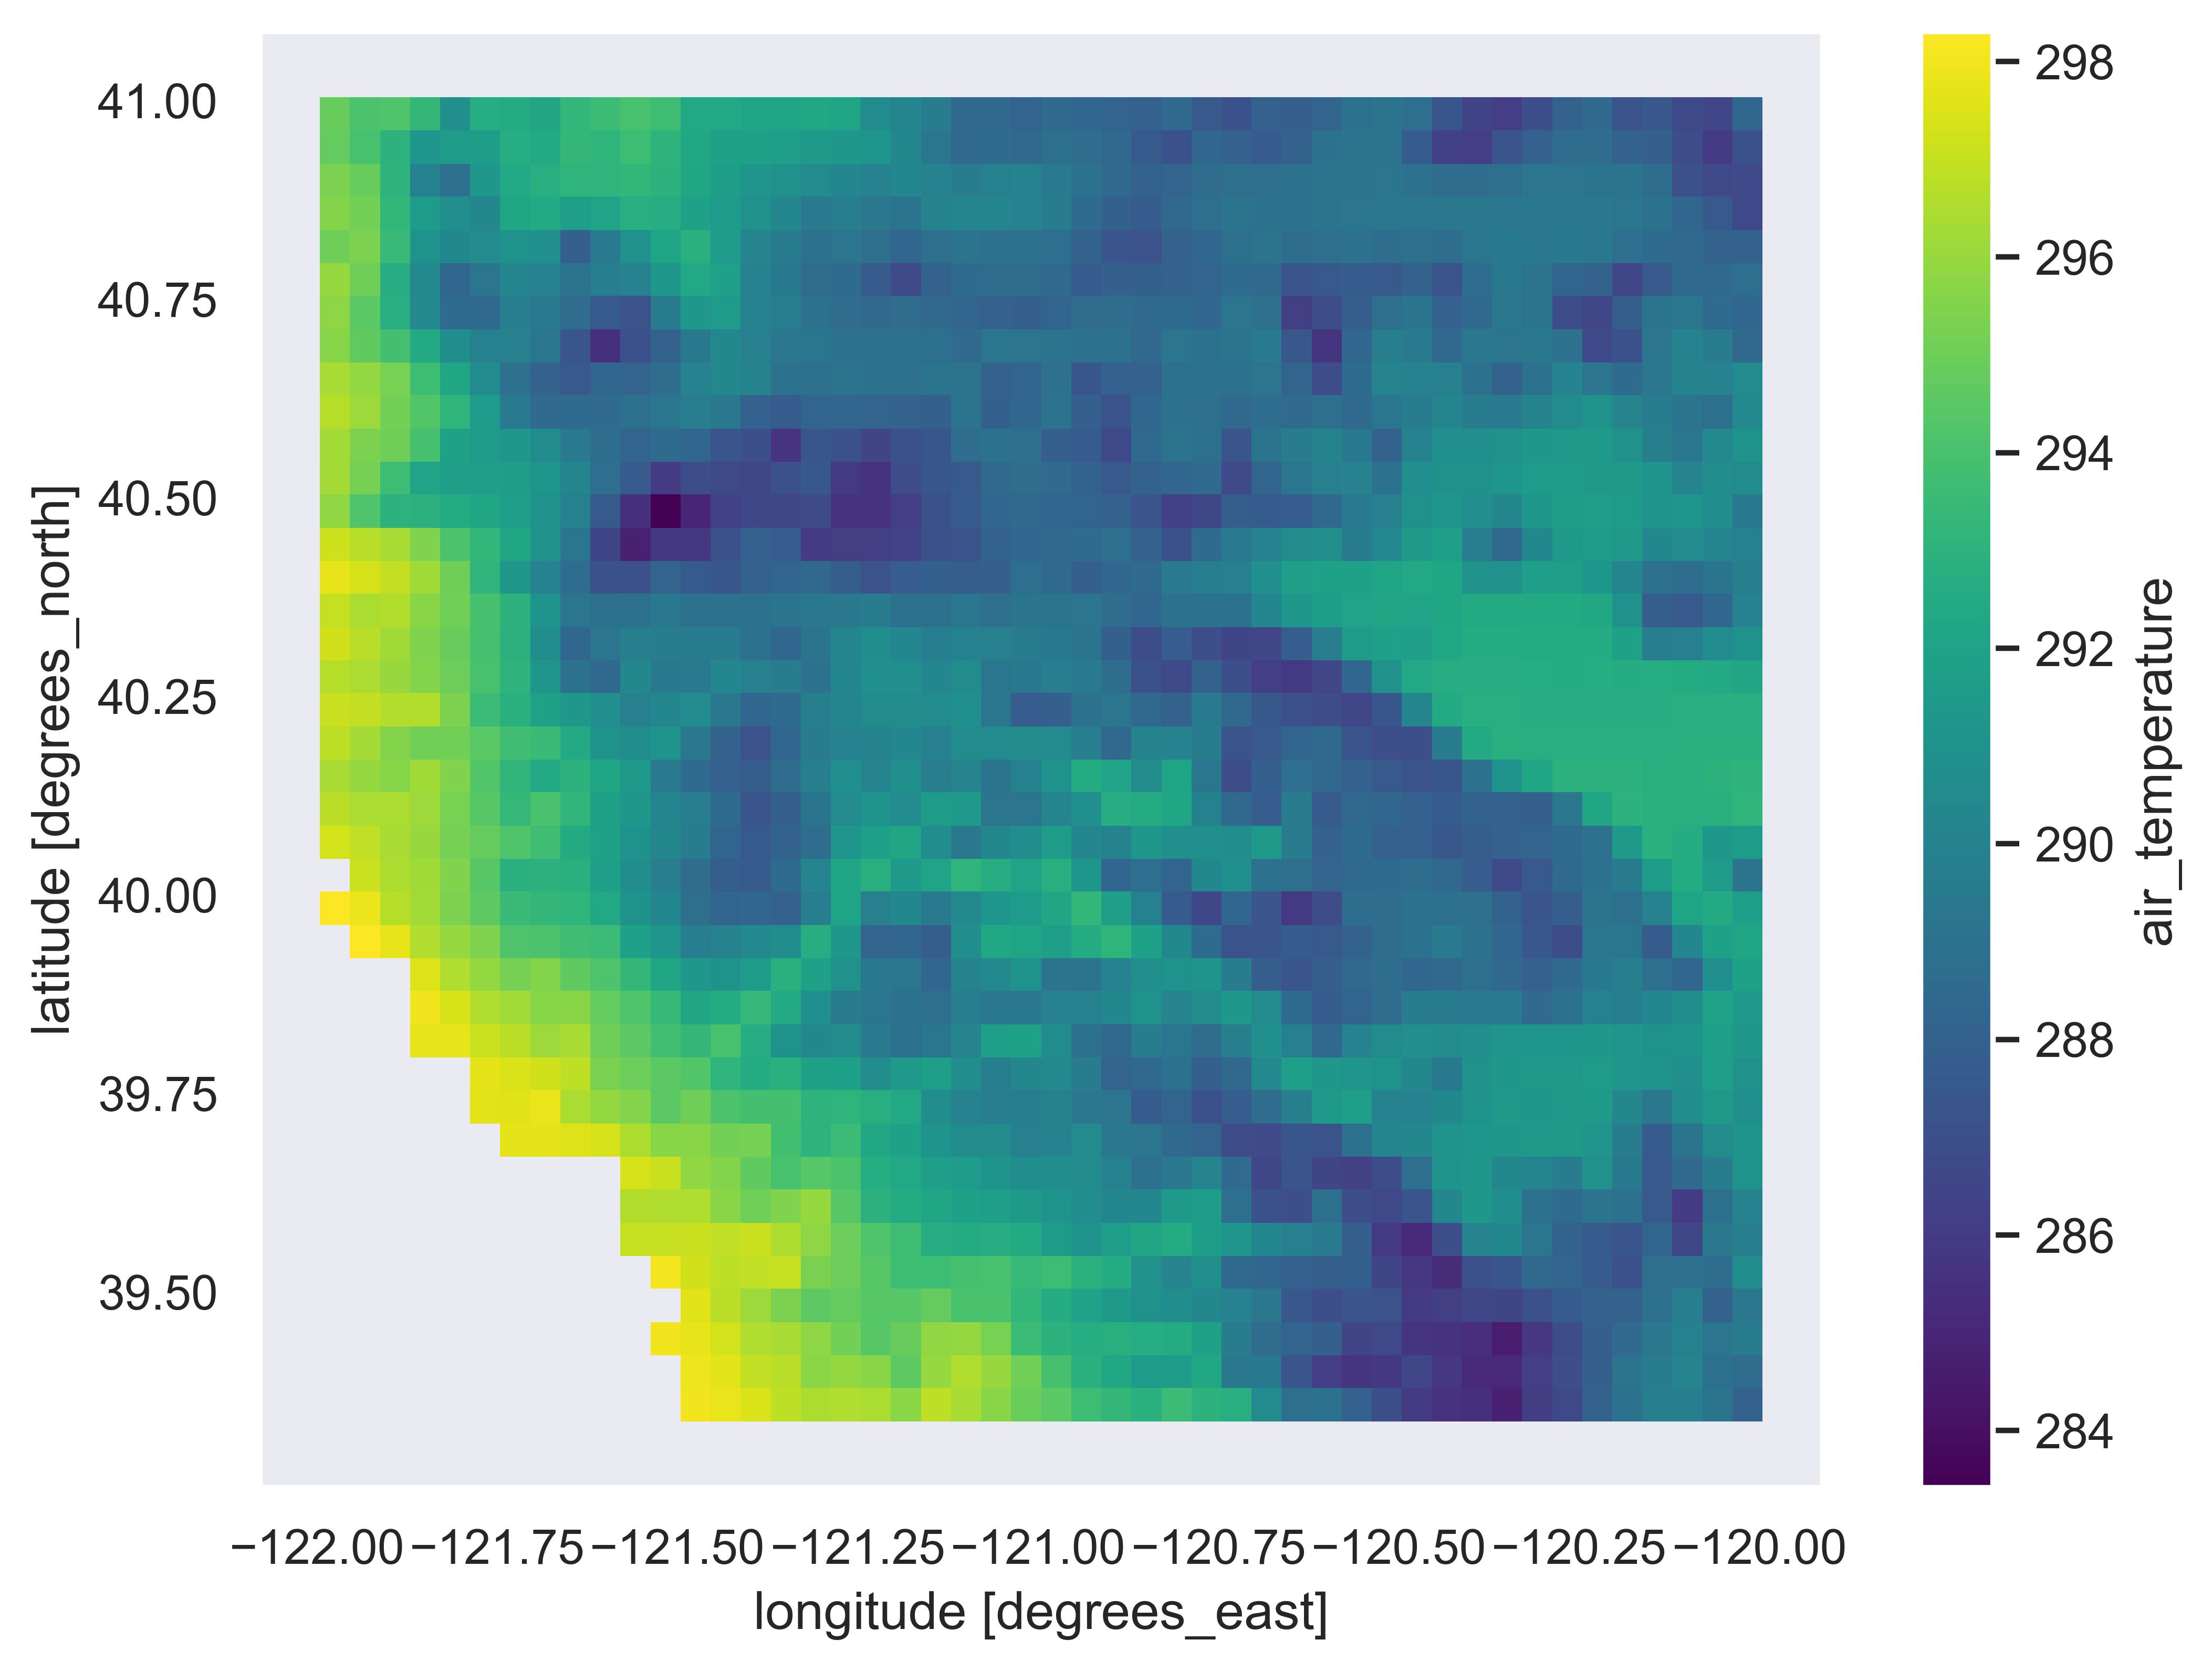

In [11]:
ds.air_temperature.mean('day').plot()

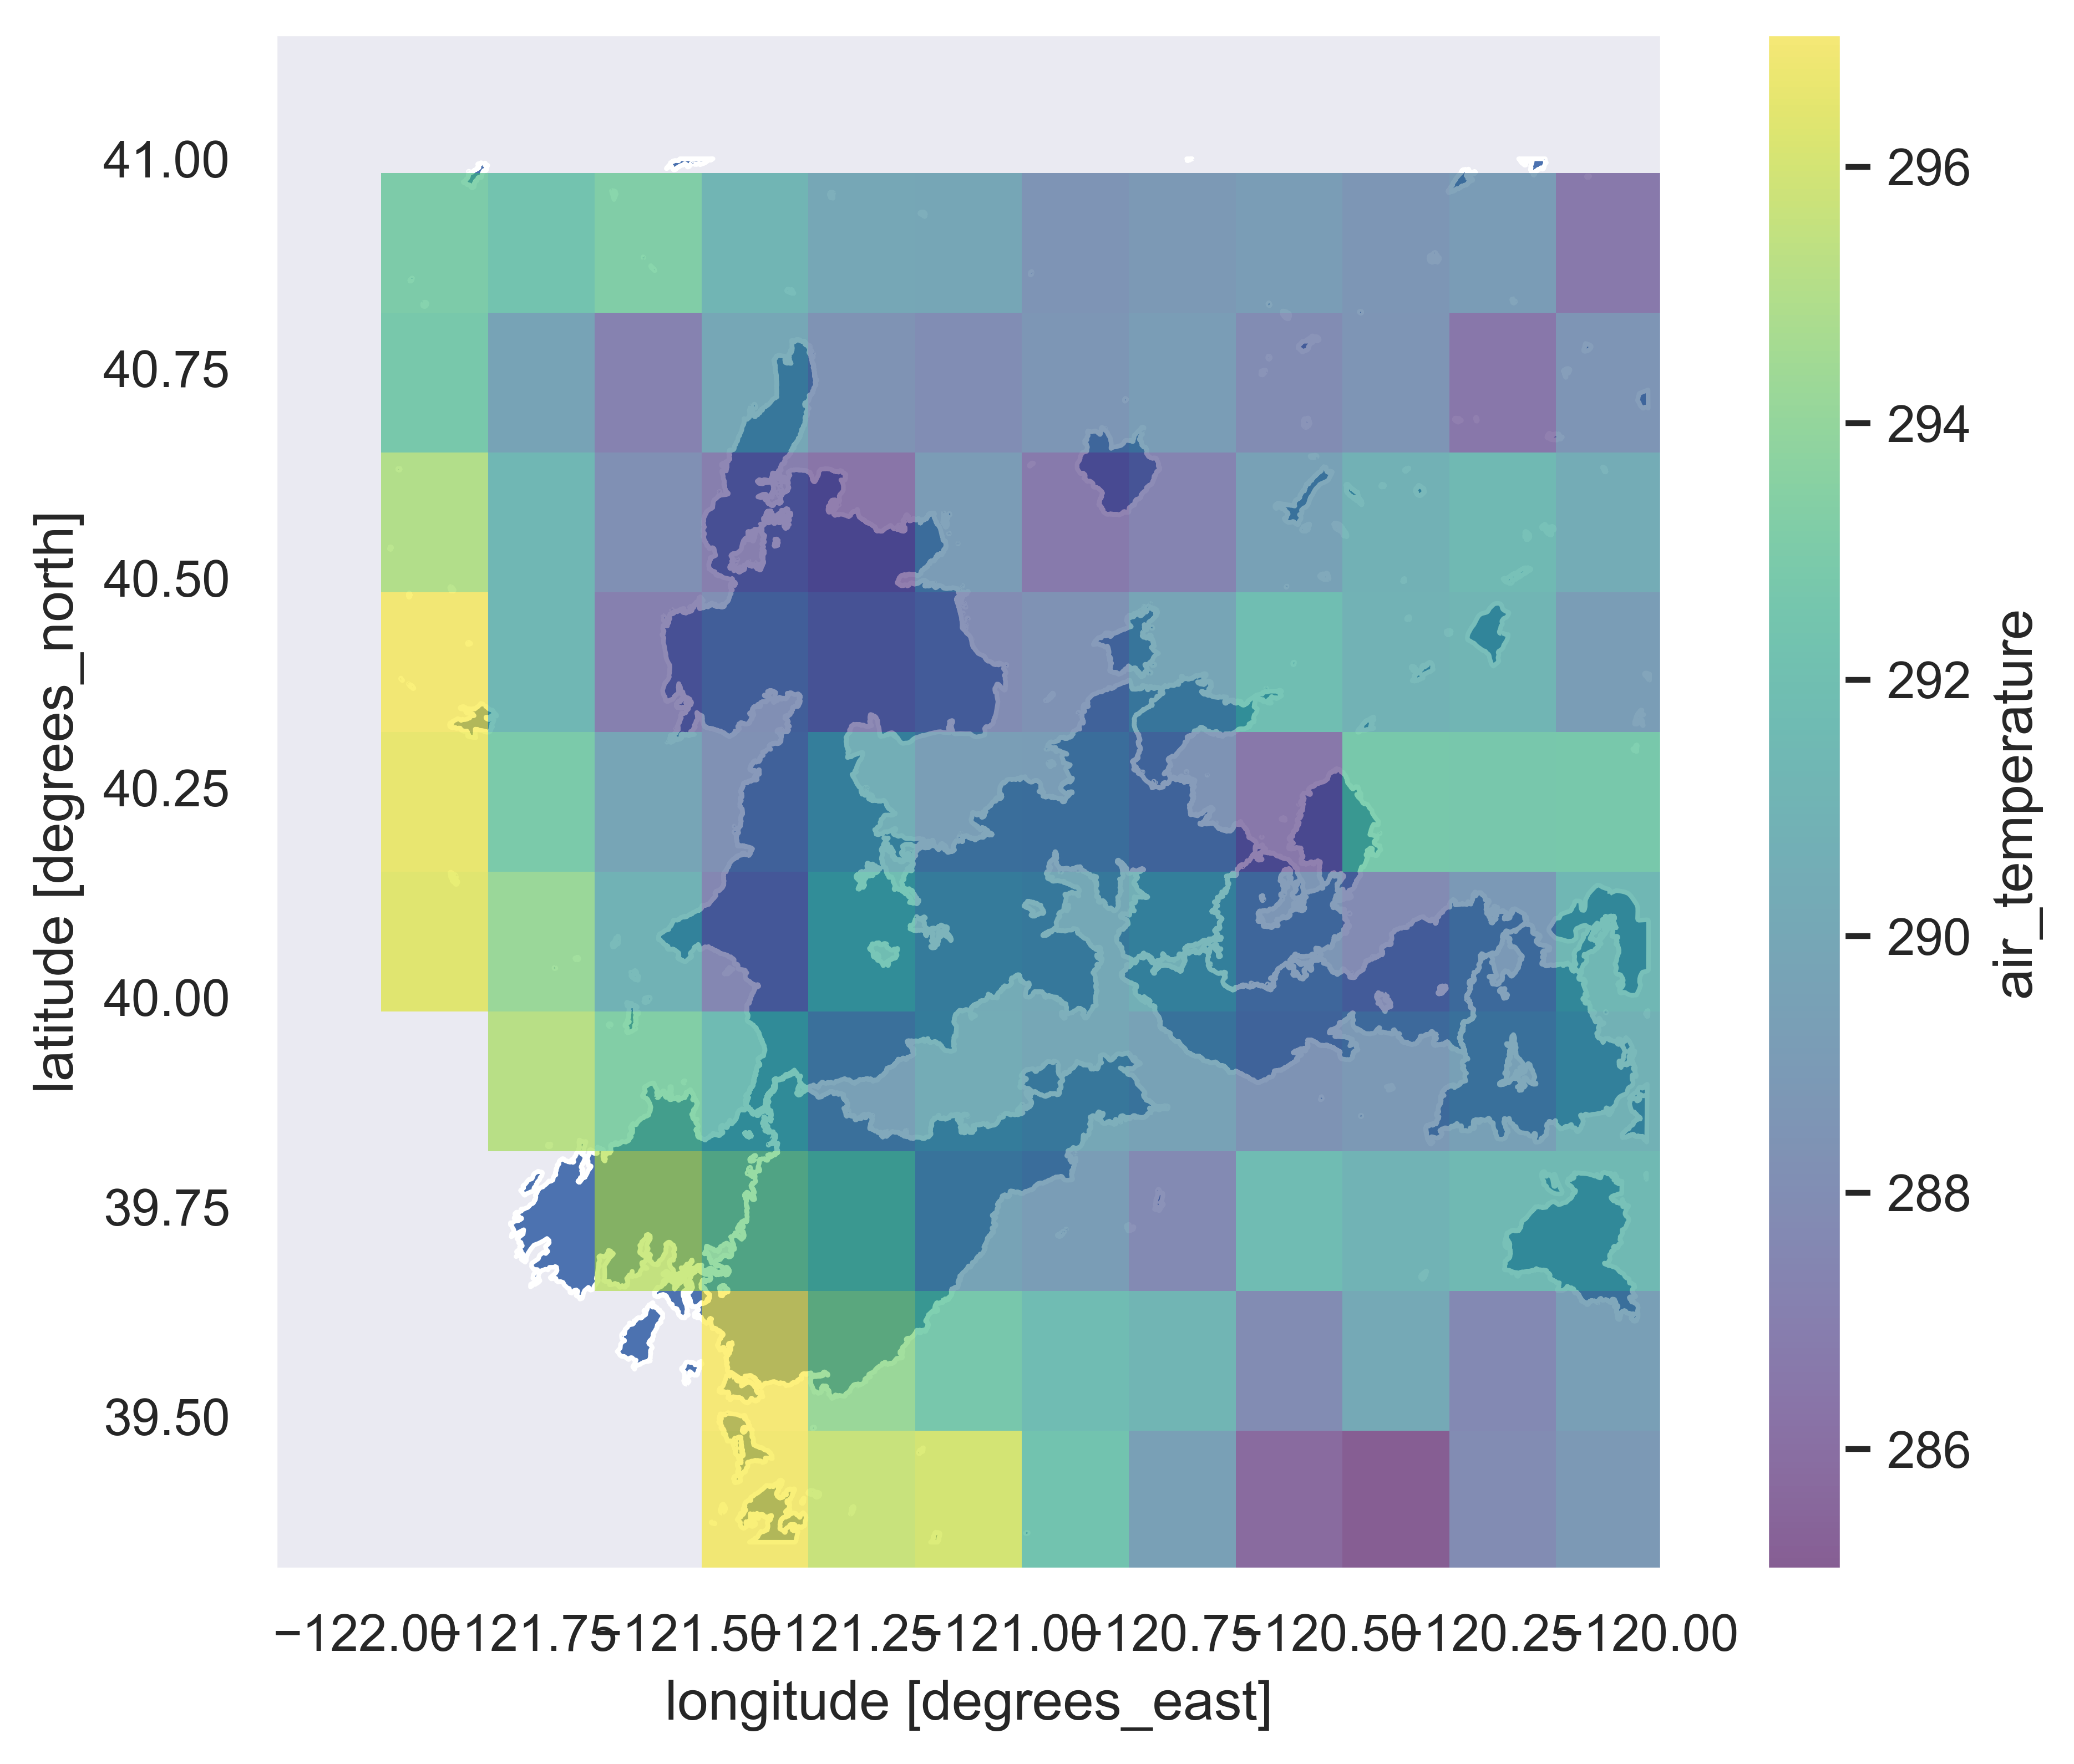

In [12]:
factor = 4
inter = ds.interp(lon=ds.lon.to_numpy()[0::factor], 
                  lat=ds.lat.to_numpy()[0::factor], 
                  method="linear")
firePer.plot()
inter.air_temperature.mean('day').plot(alpha=0.6);

In [13]:
inter

<xarray.Dataset>
Dimensions:            (day: 1826, lat: 11, lon: 13)
Coordinates:
  * day                (day) datetime64[ns] 2017-01-01 2017-01-02 ... 2021-12-31
  * lon                (lon) float64 -122.1 -121.9 -121.7 ... -120.2 -120.1
  * lat                (lat) float64 41.07 40.9 40.73 40.57 ... 39.73 39.57 39.4
Data variables:
    burning_index_g    (day, lat, lon) float64 nan nan nan nan ... 0.0 12.0 13.0
    relative_humidity  (day, lat, lon) float64 nan nan nan ... 59.5 55.2 57.9
    air_temperature    (day, lat, lon) float64 nan nan nan ... 269.4 273.2 273.6
    wind_speed         (day, lat, lon) float64 nan nan nan nan ... 3.0 3.7 5.1
Attributes:
    units:              Unitless
    description:        BI-G
    long_name:          bi
    standard_name:      bi
    dimensions:         lon lat time
    grid_mapping:       crs
    coordinate_system:  WGS84,EPSG:4326

In [14]:
# new resolution
print(abs(np.diff(inter.lon.to_numpy())))
print(abs(np.diff(inter.lat.to_numpy())))
res = abs(np.diff(inter.lon.to_numpy()))[0]

[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667
 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667
 0.16666667 0.16666667 0.16666667 0.16666667]


# Fire Column

- 0: no fire at coordinate that day
- 1: first day of fire
- 2: all other days (2nd day of fire until containment date)

- corrdinates (lon, lat) are centers of pixels, create bigger polygons (squares) to include area around coordinate
- check if coordinates intersect fire perimeters
    - 0: no intersection
    - 1: yes intersection
- check if dates had a fire
    - 0: no fire at coordinate that day
    - 1: first day of fire
    - 2: all other days (2nd day of fire until containment date)
- determine if coordinates on a day had fire

- https://gis.stackexchange.com/questions/375407/geopandas-intersects-doesnt-find-any-intersection


In [15]:
# expand coordinate points to include area around it
def getSquare(lon, lat, res):
    return Polygon([(lon+res/2,lat+res/2), (lon+res/2,lat-res/2), 
                    (lon-res/2,lat-res/2), (lon-res/2,lat+res/2)])
df = inter.to_dataframe().dropna().reset_index()
df['point'] = df.apply(lambda x: getSquare(x['lon'], x['lat'], res), axis=1)

pp = gpd.GeoSeries(df.drop_duplicates(['lat', 'lon']).point)
inp, res = firePer.geometry.sindex.query_bulk(pp, predicate='intersects')
intersects = np.isin(np.arange(0, len(pp)), inp)
intersects = np.tile(intersects,ds.day.shape[0])
df['intersects'] = intersects

In [16]:
# # check if coordinate polygon intersect with fire perimeter
# def checkIntersect(point, polygon):
#     return point.intersects(polygon)
# intersects = set()
# for polygon in firePer.geometry:
#     temp = df.apply(lambda x: checkIntersect(x['point'], polygon), axis=1)
#     for i in (temp[temp].index):
#         intersects.add(i)
# df['intersects'] = 0
# df['intersects'][intersects] = 1

In [17]:
# check if dates had fire (no, first day, others)
firstDay = set()
otherDay = set()
for i in range(len(firePer)):
    first = df[df.day == firePer.ALARM_DATE[i]]
    other = df[df.day >  firePer.ALARM_DATE[i]][df.day <= firePer.CONT_DATE[i]]
    for i in (first.index):
        firstDay.add(i)
    for i in (other.index):
        otherDay.add(i)
df['fireDate'] = 0
df['fireDate'][firstDay] = 1
df['fireDate'][otherDay] = 2

In [18]:
# determine if coordinates on a day had fire
# (intersects, fireDate) -> fire
# (0, {0,1,2}) -> 0
# (1, 0)       -> 0
# (1, 1)       -> 1
# (1, 2)       -> 2
df['intersects'] = np.where((df.intersects==0) | (df.fireDate==0), 0, df.intersects)
df['fireDate']   = np.where((df.intersects==0) | (df.fireDate==0), 0, df.fireDate)
df['fire'] = 0
df['fire'] = np.where(df.fireDate==1, 1, df.intersects)
df['fire'] = np.where(df.fireDate==2, 2, df.intersects)

In [19]:
# get useful columns
final = df[['day', 'burning_index_g', 'relative_humidity', 'air_temperature', 'wind_speed', 'fire']]
final.head()

,day,burning_index_g,relative_humidity,air_temperature,wind_speed,fire
0,2017-01-01,0.0,54.900002,275.100006,4.4,0
1,2017-01-01,0.0,43.799999,277.399994,4.4,0
2,2017-01-01,0.0,42.200001,277.600006,4.7,0
3,2017-01-01,0.0,51.400002,274.799988,5.1,0
4,2017-01-01,0.0,53.900002,274.000000,5.4,0


In [20]:
# SAVE COLUMN NAMES SOMEWHERE
with open('data/gridmetmc4.pkl', 'wb') as f: pkl.dump(final.to_numpy(), f) # save dict
with open('data/gridmetColsmc4.pkl', 'wb') as f: pkl.dump(final.columns, f) # save dict

aa = pd.DataFrame(pd.read_pickle('data/gridmetmc4.pkl'))
aa.columns = pd.read_pickle('data/gridmetColsmc4.pkl')
aa

,day,burning_index_g,relative_humidity,air_temperature,wind_speed,fire
0,2017-01-01,0.0,54.900002,275.100006,4.4,0
1,2017-01-01,0.0,43.799999,277.399994,4.4,0
2,2017-01-01,0.0,42.200001,277.600006,4.7,0
3,2017-01-01,0.0,51.400002,274.799988,5.1,0
4,2017-01-01,0.0,53.900002,274.0,5.4,0
...,...,...,...,...,...,...
202681,2021-12-31,12.0,47.299999,275.799988,2.7,0
202682,2021-12-31,0.0,47.700001,271.700012,2.9,0
202683,2021-12-31,0.0,59.5,269.399994,3.0,0
202684,2021-12-31,12.0,55.200001,273.200012,3.7,0


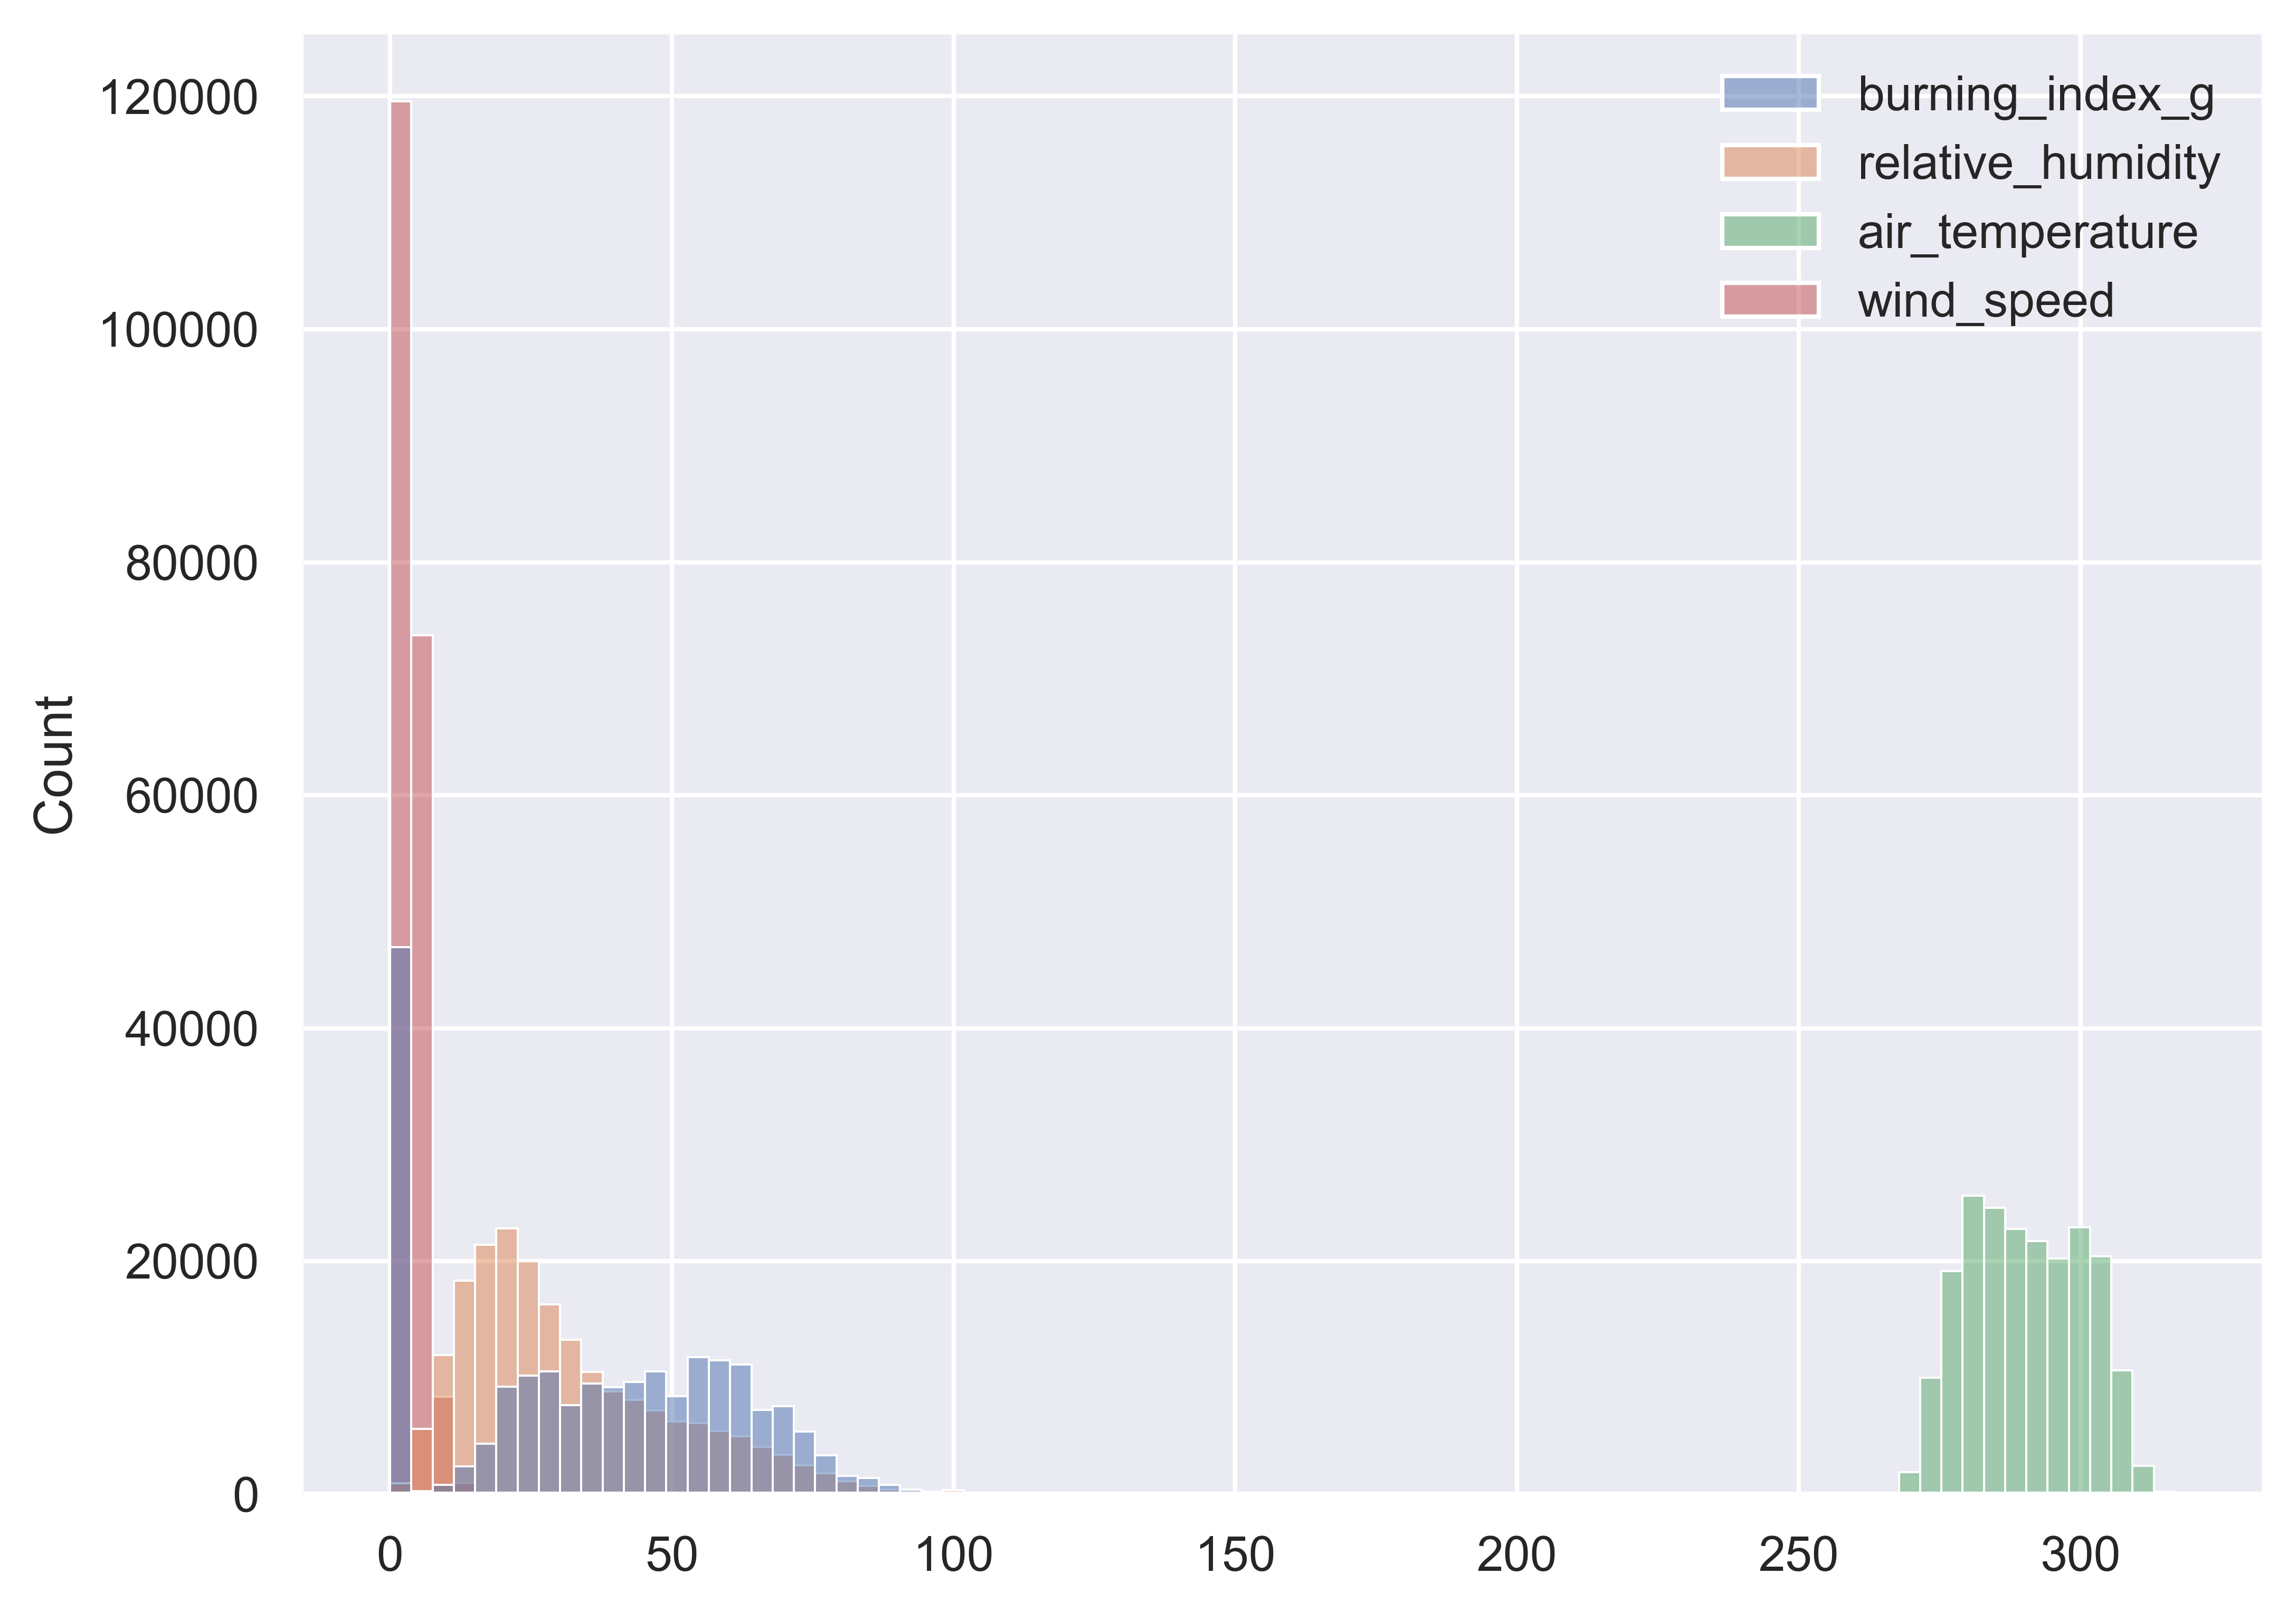

In [21]:
sns.histplot(aa.drop(['day', 'fire'], axis=1));
# plt.legend()

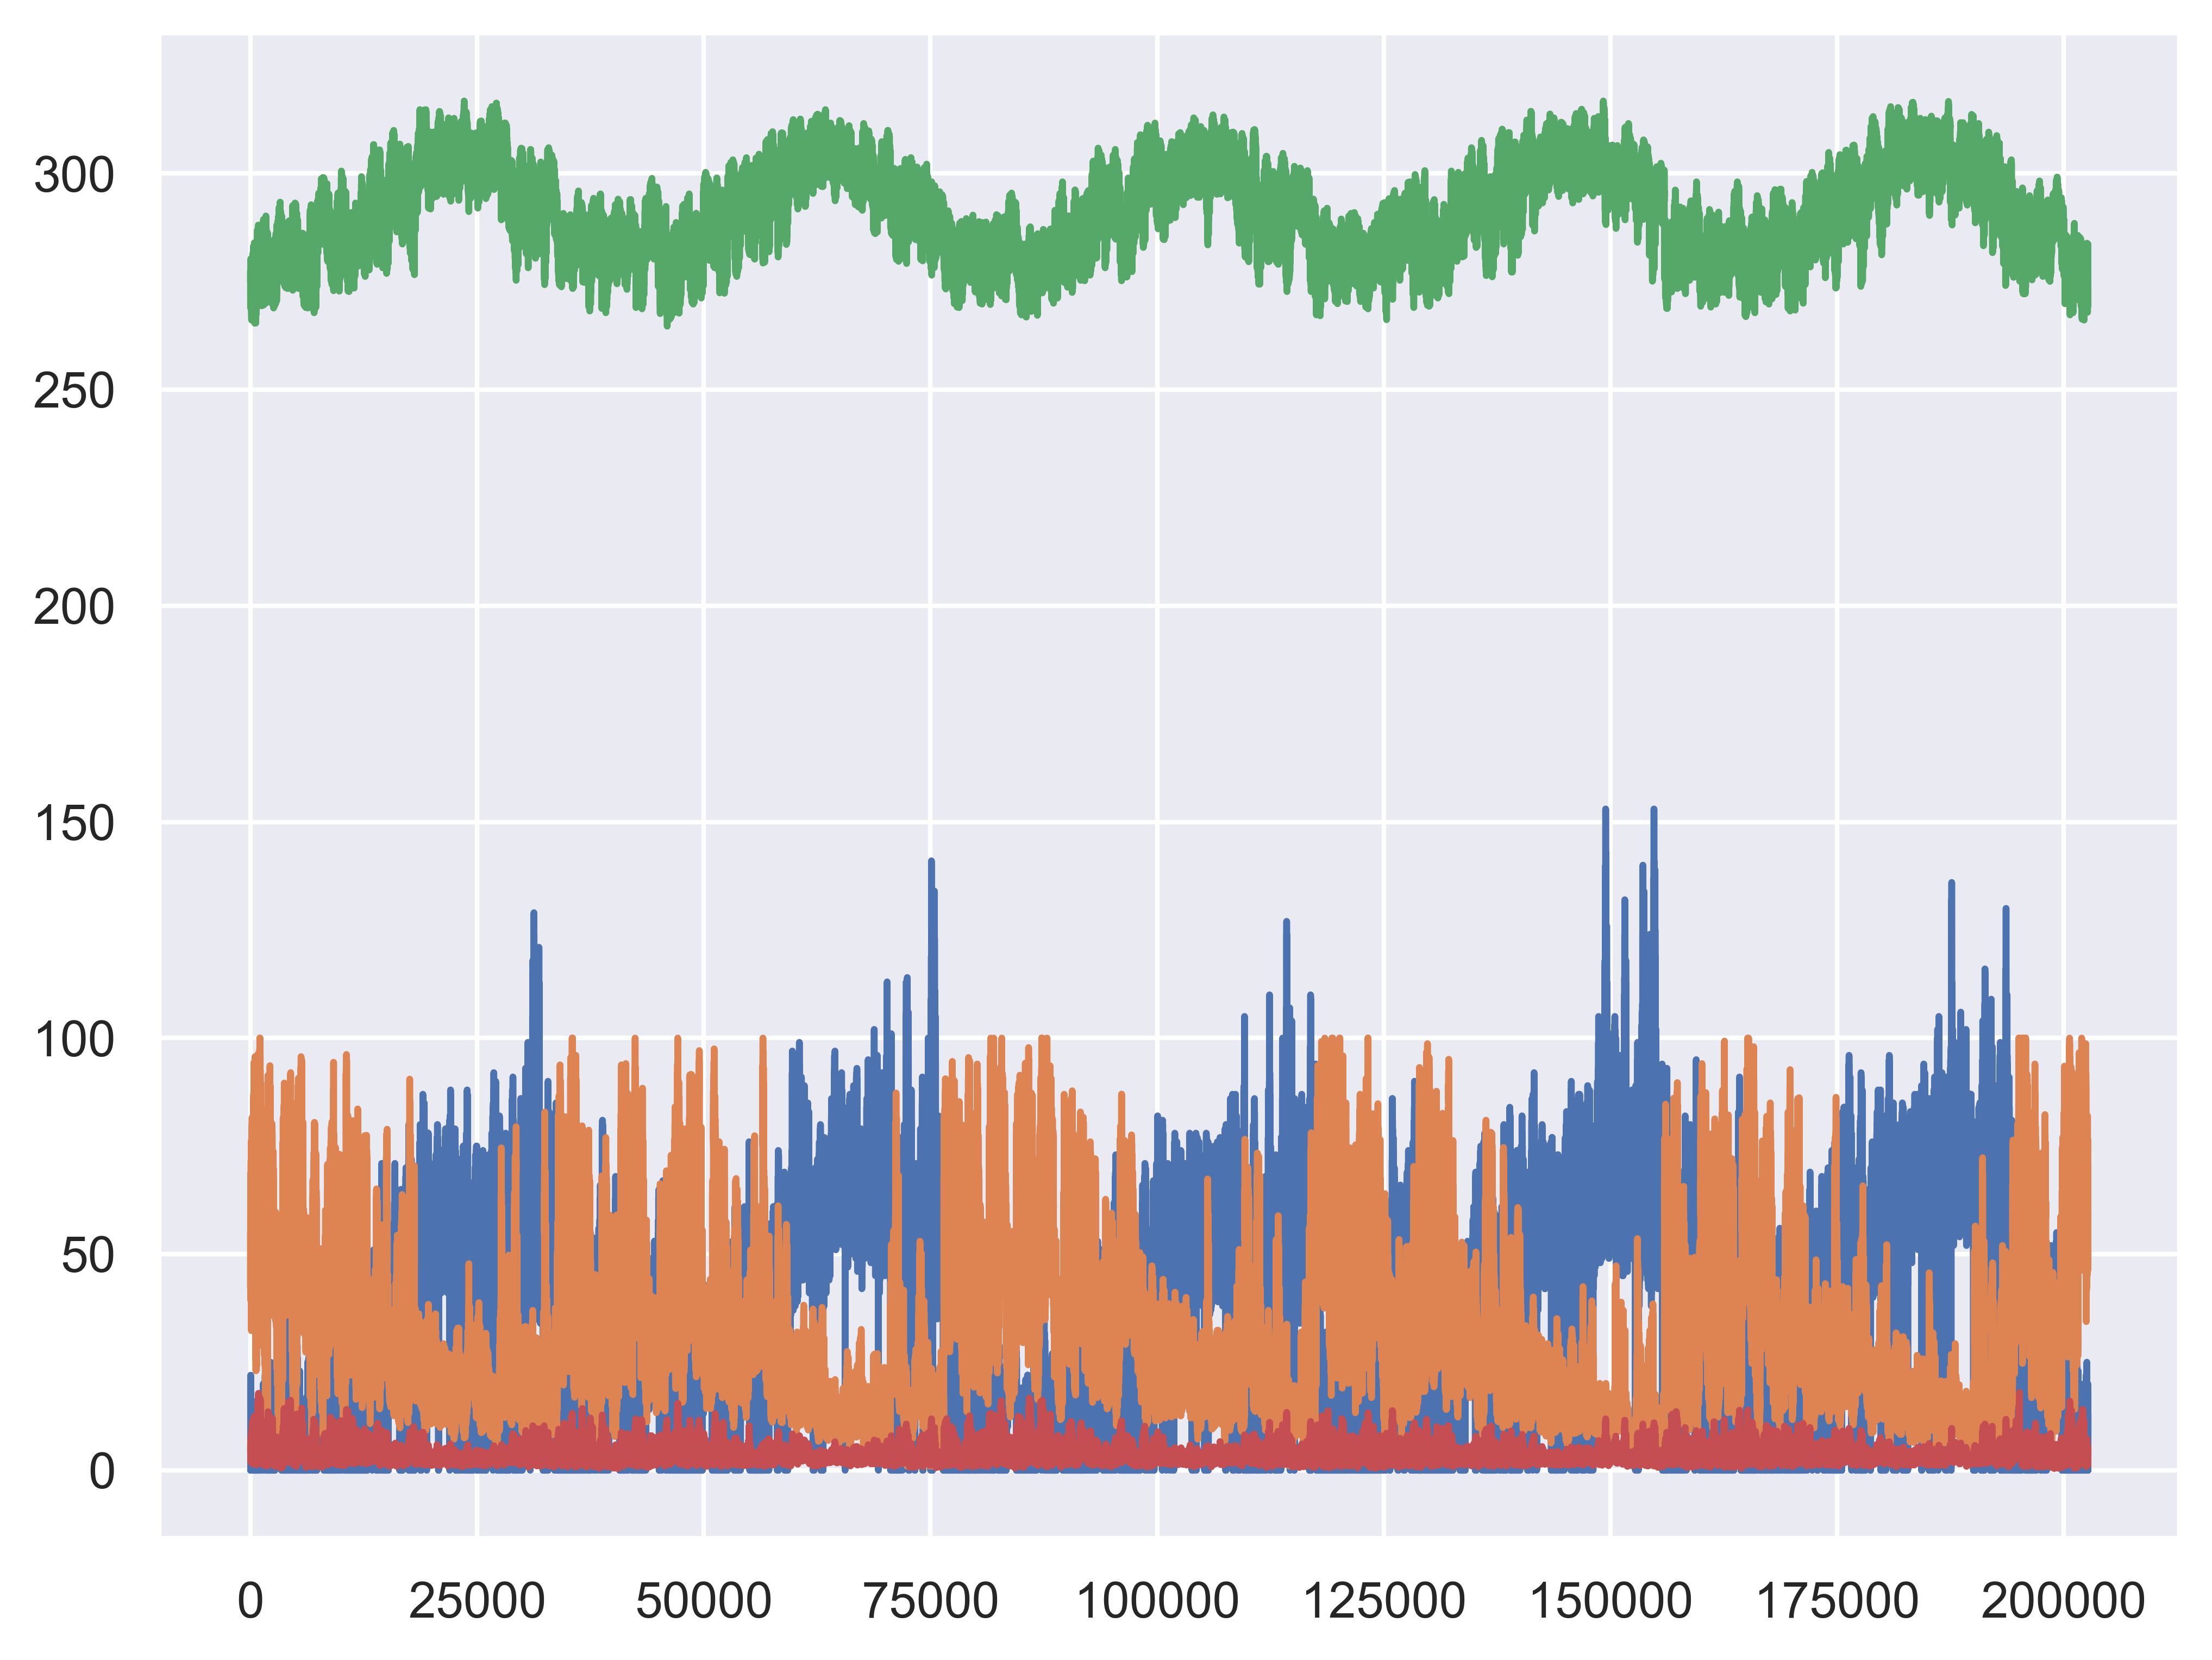

In [22]:
plt.plot(aa.drop(['day', 'fire'], axis=1));
